## Introduction to SpaCy
SpaCy is one of the main libraries for NLP in Python. It is especially tailored towards the (development and) deployment of pipelines for a number of NLP tasks, from named entity recognition to dependency parsing. Recent additions to spaCy also make it possible to use advanced models (LLMs) as building block for such pipelines. 

In this notebook, we will explore some of SpaCy's basic functionality. As we will mainly focus on understanding and implementing methods to represent and generate text, we will not be using SpaCy extensively for the rest of the course -- but it is a great tool for many applications, and it has wonderful documentation.

Let's start by importing SpaCy.
You may need to install this first (I am using `spacy==3.6.1`) -- add it to your requirements file if you have one.

In [2]:
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
from collections import defaultdict
from sklearn.decomposition import PCA

When spaCy is loaded, we then need to initialize a model.

NB: Models first have to be downloaded from the command line. An overview of avaiable models from spaCy can be found [here](https://spacy.io/usage/models):
```
python -m spacy download en_core_web_md
```
Note that models for a wide range of languages are available on SpaCy, feel free to experiment!

In [3]:
nlp = spacy.load("en_core_web_md")

We first create a `spaCy` pipeline which is going to be used for all of our analysis. Essentially we feed our examples of language down the pipeline, and get annotated texts out the end. Let's load the first 10 chapters of "War and Peace", the text file we worked with last week.

In [4]:
book = open('../data/book-war-and-peace.txt').read()

In [6]:
print(book[:2000])

CHAPTER I

"Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by that
Antichrist--I really believe he is Antichrist--I will have nothing more
to do with you and you are no longer my friend, no longer my 'faithful
slave,' as you call yourself! But how do you do? I see I have frightened
you--sit down and tell me all the news."

It was in July, 1805, and the speaker was the well-known Anna Pavlovna
Scherer, maid of honor and favorite of the Empress Marya Fedorovna. With
these words she greeted Prince Vasili Kuragin, a man of high rank and
importance, who was the first to arrive at her reception. Anna Pavlovna
had had a cough for some days. She was, as she said, suffering from la
grippe; grippe being then a new word in St. Petersburg, used only by the
elite.

All her invitations without exception, written in French, and delivered
by a scar

Let's now find where chapter 10 starts, and only keep text until there.

In [7]:
chap_10_index = re.search('CHAPTER X', book).start()
book = book[:chap_10_index]

The final object that comes out of the end is known as a `spaCy` `Doc` which is essentially a list of tokens. However, rather than just being a list of strings, each of the tokens in this list have their own attributes, which can be accessed using the dot notation.

In [8]:
doc = nlp(book)

The resulting `doc` parses the text in sentences and tokens within sentences.

In [9]:
for s in doc.sents:
    print(s)
    for t in s:
        print(t)

CHAPTER I

"Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes.
CHAPTER
I



"
Well
,
Prince
,
so
Genoa
and
Lucca
are
now
just
family
estates
of
the


Buonapartes
.
But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by that
Antichrist--I really believe he is Antichrist--I will have nothing more
to do with you and you are no longer my friend, no longer my 'faithful
slave,' as you call yourself!
But
I
warn
you
,
if
you
do
n't
tell
me
that
this
means
war
,


if
you
still
try
to
defend
the
infamies
and
horrors
perpetrated
by
that


Antichrist
--
I
really
believe
he
is
Antichrist
--
I
will
have
nothing
more


to
do
with
you
and
you
are
no
longer
my
friend
,
no
longer
my
'
faithful


slave
,
'
as
you
call
yourself
!
But how do you do?
But
how
do
you
do
?
I see I have frightened
you--sit down and tell me all the news.
I
see
I
have
frightened


you
--
sit
down
and
tell
me
all
the
news
.
"

It wa

Each token in the doc is annotated for a number of attributes.

In [10]:
i = 0
for token in doc:
    i += 1
    print(token.text, "\t\t", token.pos_, "\t\t", token.dep_,"\t\t", token.lemma_, "\t\t")
    if i == 50:
        break

CHAPTER 		 PROPN 		 prep 		 CHAPTER 		
I 		 PRON 		 pobj 		 I 		


 		 SPACE 		 dep 		 

 		
" 		 PUNCT 		 punct 		 " 		
Well 		 INTJ 		 intj 		 well 		
, 		 PUNCT 		 punct 		 , 		
Prince 		 PROPN 		 appos 		 Prince 		
, 		 PUNCT 		 punct 		 , 		
so 		 ADV 		 advmod 		 so 		
Genoa 		 PROPN 		 nsubj 		 Genoa 		
and 		 CCONJ 		 cc 		 and 		
Lucca 		 PROPN 		 conj 		 Lucca 		
are 		 AUX 		 ROOT 		 be 		
now 		 ADV 		 advmod 		 now 		
just 		 ADV 		 advmod 		 just 		
family 		 NOUN 		 compound 		 family 		
estates 		 NOUN 		 attr 		 estate 		
of 		 ADP 		 prep 		 of 		
the 		 DET 		 det 		 the 		

 		 SPACE 		 dep 		 
 		
Buonapartes 		 PROPN 		 pobj 		 Buonapartes 		
. 		 PUNCT 		 punct 		 . 		
But 		 CCONJ 		 cc 		 but 		
I 		 PRON 		 nsubj 		 I 		
warn 		 VERB 		 ccomp 		 warn 		
you 		 PRON 		 dobj 		 you 		
, 		 PUNCT 		 punct 		 , 		
if 		 SCONJ 		 mark 		 if 		
you 		 PRON 		 nsubj 		 you 		
do 		 AUX 		 aux 		 do 		
n't 		 PART 		 neg 		 not 		
tell 		 VERB 		 advcl 		 tell 		
me 	

### Exploring named entities

Let's explore one of the features of spaCy: named entity recognition. These are all the named entities spaCy finds in the text.

In [11]:
doc.ents

(Prince,
 Genoa,
 Lucca,
 Buonapartes,
 Antichrist,
 July,
 1805,
 Anna Pavlovna
 Scherer,
 Empress,
 Marya Fedorovna,
 Prince Vasili Kuragin,
 first,
 Anna Pavlovna,
 some days,
 St. Petersburg,
 French,
 footman,
 morning,
 tonight,
 Scherer,
 French,
 Anna Pavlovna,
 First,
 Anna Pavlovna,
 English,
 Today,
 Wednesday,
 today,
 Novosiltsev,
 Buonaparte,
 Prince Vasili,
 Anna Pavlovna Scherer,
 forty years,
 Anna Pavlovna,
 Austria,
 Austria,
 Russia,
 Europe,
 one,
 one,
 England,
 Alexander,
 Malta,
 Novosiltsev,
 English,
 Prussia,
 Buonaparte,
 Europe,
 Hardenburg,
 Haugwitz,
 Prussian,
 Europe,
 Wintzingerode,
 Prussia,
 two,
 tonight,
 Vicomte de Mortemart,
 Rohans,
 one,
 French,
 the Abbe Morio,
 the Dowager Empress,
 first,
 Vienna,
 Prince Vasili,
 Marya Fedorovna,
 Anna Pavlovna,
 Empress,
 Funke,
 the Dowager Empress,
 Empress,
 Anna Pavlovna's,
 d'estime,
 Anna Pavlovna,
 Empress,
 two,
 Anatole,
 Two,
 Majesty,
 Hippolyte,
 Anatole,
 Anna Pavlovna,
 Anna Pavlovna,
 Anat

SpaCy also has some nice utils to visualize like named entities or dependency relations between individual words (try replace `ent` with `dep`). Let's see how this looks:

In [12]:
spacy.displacy.serve(doc[:300], style="ent")

/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/spacy/displacy/__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


Now let's try to look at the frequency of each entity, and see what information we can extract on the characters named in the book.

In [13]:
entity_counts = defaultdict(lambda: 0)
for e in doc.ents:
    if e.label_ == 'PERSON':
        entity_counts[e.text] += 1

In [14]:
import pandas as pd
entity_df = pd.DataFrame.from_dict(entity_counts, 
                                   orient='index').reset_index()
entity_df = entity_df.rename({'index': 'entity', 0: 'count'}, axis=1).sort_values(by='count', ascending=False)

In [15]:
entity_df

,entity,count
29,Pierre,98
5,Anna Pavlovna,55
43,Prince Andrew,39
84,Dolokhov,26
36,Prince Hippolyte,16
...,...,...
57,Louis XVII,1
58,Queen,1
59,Elizabeth,1
16,Mary\nBolkonskaya,1


/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

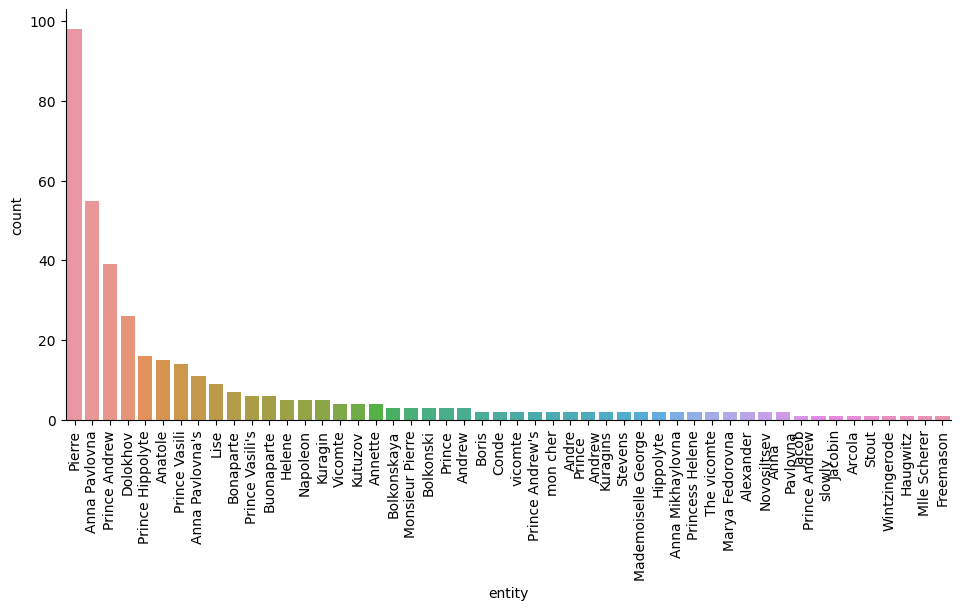

In [16]:
sns.catplot(data=entity_df.head(n=50), x='entity', y='count', kind='bar', height=5, aspect=2)
plt.xticks(rotation=90)
plt.show()

We have a pretty accurate model of who they main characters in War and Peace are! You may notice that some entities are actually duplicates (`Anna Pavlovna` and `Anna Pavlovna's`: these could in principle be manually normalized or, more elegantly, clustered using pipelines for a task called "coreference resolution"). 

### Character time series
As a demonstration of what you can do with this, let's focus on the top 3 characters. Can we plot a time series, visualizing how many times they are mentioned in each of the 9 chapters?

In [17]:
idxs = []
for t in doc:
    if t.text == 'CHAPTER':
        idxs.append(t.idx) # append start index of the chapter

In [18]:
char_count_by_chapter = dict(zip(entity_df.entity.head(n=3).tolist(),
                                 [dict(zip(range(1,10),[0]*9)),
                                  dict(zip(range(1,10),[0]*9)),
                                  dict(zip(range(1,10),[0]*9))])) # there are more elegant ways to do this, with defaultdict

for e in doc.ents:
    if e.text in char_count_by_chapter.keys():
        for nr, i in enumerate(idxs):
            if e.start_char < i:
                char_count_by_chapter[e.text][nr] += 1 # is this correct?
                break
            else:
                if nr == 8:
                    char_count_by_chapter[e.text][9] += 1


In [19]:
dfs = []
for k,v in char_count_by_chapter.items():
    df = pd.DataFrame.from_dict(v, orient='index').reset_index().rename({'index': 'chapter',
                                                                         0: 'count'}, axis=1)
    df['character'] = k
    dfs.append(df)
char_df = pd.concat(dfs)

/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='chapter', ylabel='count'>

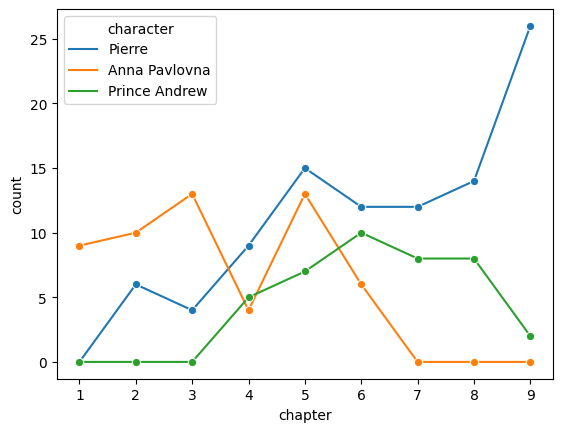

In [20]:
sns.lineplot(data=char_df, x='chapter', y='count', hue='character', marker='o')

## Word vectors
One of the attributes that spaCy models provide is easy access to word vectors. These are not based on counts, but on more sophisticated algorithms that we will look into in detail next week, but the intuition is the same as count-based vectors. Let's use this to put some of the notions we explored in our lecture into practice. First, let's take a look at some of the tokens in our text

In [21]:
for i, t in enumerate(doc[:20]):
    print(i, t.text)

0 CHAPTER
1 I
2 


3 "
4 Well
5 ,
6 Prince
7 ,
8 so
9 Genoa
10 and
11 Lucca
12 are
13 now
14 just
15 family
16 estates
17 of
18 the
19 



Let's focus on the token "family" (occurring, e.g., at index 15). We want to identify the words that are most similar to family (of those present in the text). With SpaCy, we can compute cosine similarity between vectors using in-build functionality. The following piece of code computes the similarity between "family" (the token at index 15) and "estates" (the token at index 16).

In [22]:
doc[15].similarity(doc[16])

0.5541646480560303

Based on this, can you identify the 20 tokens, of those occurring in our doc, whose vectors are *most similar* to "family"? Do the results make sense?

In [23]:
sims = {}
for i, t in enumerate(doc):
    if t.text not in sims.keys():
        cosine_sim = doc[15].similarity(doc[i])
        sims[t.text] = cosine_sim
cos_df = pd.DataFrame.from_dict(sims, orient='index').reset_index() 
cos_df.columns=['token', 'cosine_sim']
cos_df = cos_df.sort_values(by='cosine_sim', ascending=False)


/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_11955/2327433324.py:4: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  cosine_sim = doc[15].similarity(doc[i])


In [24]:
cos_df.head(n=20)

,token,cosine_sim
14,family,1.000000
496,families,0.742622
899,mother,0.670364
650,father,0.669876
195,grandfathers,0.653718
2184,friends,0.610817
739,brother,0.591992
722,fathers,0.590159
1609,mothers,0.583737
1577,friendship,0.572327


This looks very promising: can you do the same with other words? What happens if you look at the *most dissimilar* words?

In [25]:
cos_df.tail(n=20)

,token,cosine_sim
519,Funke,-0.106777
1290,Wait,-0.107927
163,7,-0.109517
164,10,-0.110373
2154,de-,-0.111380
808,femme,-0.111893
631,bump,-0.113940
286,Do,-0.114494
1956,gasps,-0.140330
939,Mind,-0.145291


Finally, let's visualize some vectors. Let's sample 200 random nouns, reduce the vector dimensionality with a technique called principal component analysis, and let's visualize the resulting space.

In [26]:
random_indices = []
for i, t in enumerate(doc):
    if t.pos_ == 'NOUN':
        random_indices.append(i)
        if len(random_indices) == 200:
            break

In [27]:
pca = PCA(n_components=2)
vectors = np.vstack([doc[i].vector for i in random_indices])
reduced_vectors = pca.fit_transform(vectors) # transform into a 2d space

In [28]:
reduced_vectors

array([[  3.1791873 ,  15.339206  ],
       [-12.254094  ,  19.101019  ],
       [ -6.8910604 ,  46.339653  ],
       [  2.1653078 ,  -2.9467793 ],
       [  7.2690945 ,  -6.617448  ],
       [ 18.259592  ,   5.9544735 ],
       [  9.281531  ,  18.941483  ],
       [ -5.113909  ,  -4.8473787 ],
       [ -5.3348064 ,  -3.6367483 ],
       [  6.2168536 ,  13.377741  ],
       [  3.4246476 ,  -9.371872  ],
       [  3.7312877 , -14.444042  ],
       [ 41.130756  ,  10.802436  ],
       [ -6.48769   ,  11.063397  ],
       [-22.040815  ,  -0.0496877 ],
       [-17.90493   ,  -0.50307417],
       [  1.8021581 ,  -9.945544  ],
       [ -0.86825967,  -1.5576049 ],
       [  7.240695  , -21.320314  ],
       [  7.240695  , -21.320314  ],
       [  7.803142  , -13.50982   ],
       [ -1.3209453 ,   9.3564    ],
       [-19.756336  ,   0.54801446],
       [-16.89398   ,   1.5303258 ],
       [  0.12953538,  -6.059676  ],
       [ -3.8488781 ,  -0.75060993],
       [ -6.713626  ,  -2.817184  ],
 

Now let's plot the reduced vectors in 2D space:

/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/au571533/venvs/nlp-e23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


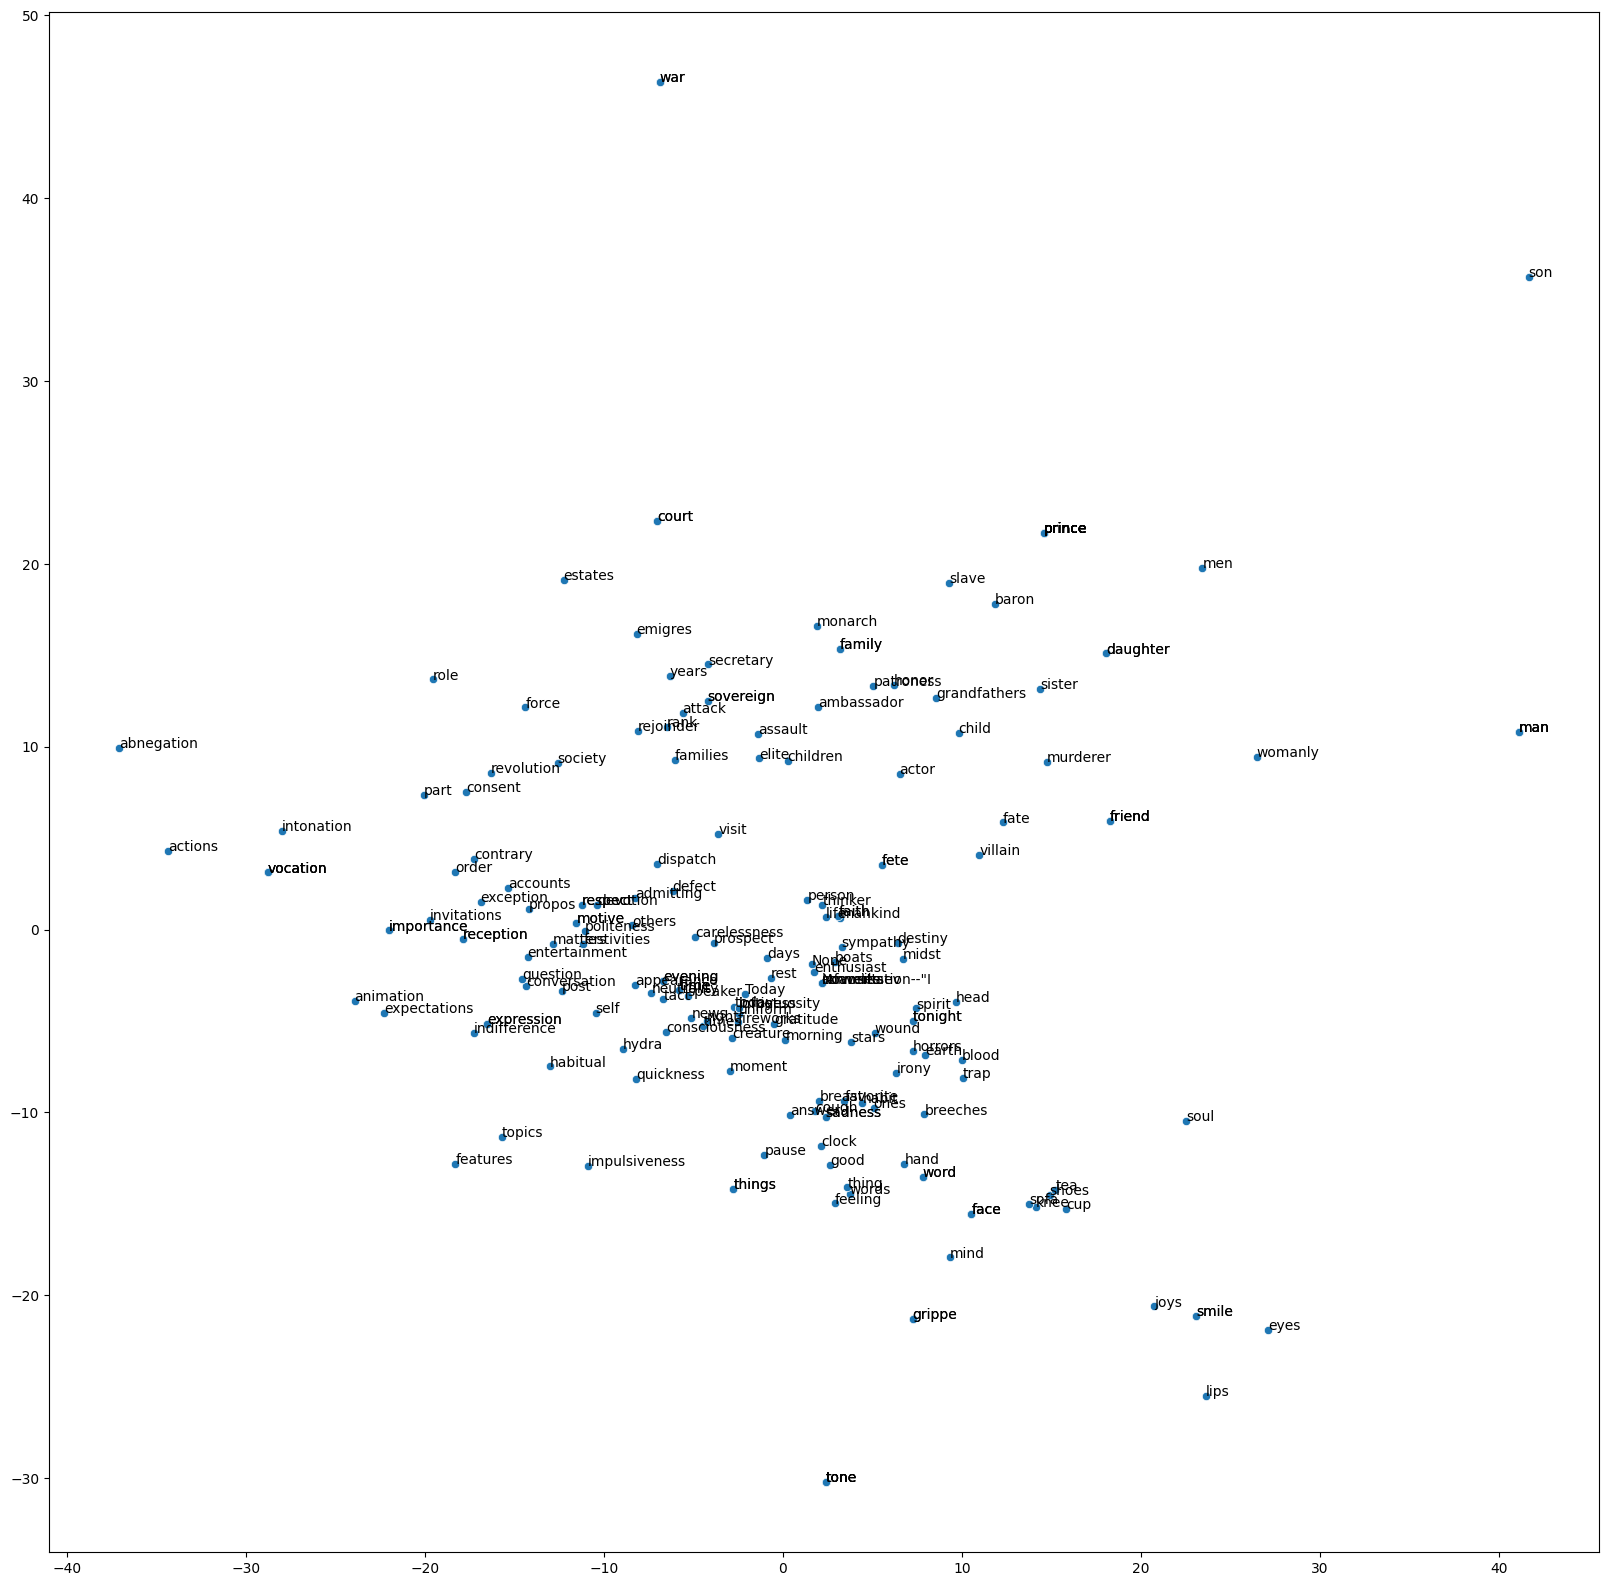

In [29]:
plt.subplots(figsize=(20,20))
sns.scatterplot(x=reduced_vectors[:200,0], y=reduced_vectors[:200,1])
for i in range(200):
    plt.text(reduced_vectors[i,0], 
             reduced_vectors[i,1], 
             doc[random_indices[i]])

Do you notice anything promising in terms of relations between vectors?

Note that you can also use `scikit-learn` to compute `euclidean_distances` and `cosine_similarity`, see: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise. These functions require a matrix as input, and they compute all pairwise similarities between rows of the matrix.

**Optional**: can you implement your own versions functions to compute euclidean distance and cosine similarity? Look at the formulas from Lecture 2, and use `spaCy` or `scikit-learn` functions to check that they are correct. We will experiment more with word vectors next week.

## Task
In the shared data drive on UCloud, there is a folder called `data`, where you can find a file called `News_Category_Dataset_v2.json`. This is taken from [this Kaggle exercise](https://www.kaggle.com/datasets/rmisra/news-category-dataset) and comprises some 200k news headlines from [HuffPost](https://www.huffpost.com/). The data is a json lines format, with one JSON object per row. You can load this data into pandas in the following way:
```
data = pd.read_json(filepath, lines=True)
```
Select a couple of sub-categories of news data and use spaCy to find the relative frequency per **10k words** of each of the following word classes - NOUN, VERB, ADJECTIVE, ADVERB (in the headlines).
Save the results as a CSV file (again using pandas).
Are there any differences in the distributions?

In [30]:
import pandas as pd

In [33]:
df = pd.read_json('../data/News_Category_Dataset_v3.json', lines=True) # path to files on UCloud

In [73]:
df.category.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [82]:
df = df[df['category'].isin(['COMEDY', 'CRIME', 'POLITICS'])]

In [85]:
df[df['category']=='COMEDY'] # ['headline'].tolist()

,link,headline,category,short_description,authors,date
21,https://www.huffpost.com/entry/biden-us-forces...,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,,2022-09-19
24,https://www.huffpost.com/entry/ukraine-festiva...,‘Beautiful And Sad At The Same Time’: Ukrainia...,POLITICS,An annual celebration took on a different feel...,Jonathan Nicholson,2022-09-19
30,https://www.huffpost.com/entry/europe-britain-...,Biden Says Queen's Death Left 'Giant Hole' For...,POLITICS,"U.S. President Joe Biden, in London for the fu...","Darlene Superville, AP",2022-09-18
40,https://www.huffpost.com/entry/afghan-adjustme...,Bill To Help Afghans Who Escaped Taliban Faces...,POLITICS,Republican outrage over the shoddy U.S. withdr...,Hamed Ahmadi and Arthur Delaney,2022-09-16
44,https://www.huffpost.com/entry/capitol-riot-in...,Mark Meadows Complies With Justice Dept. Subpo...,POLITICS,The former White House chief of staff has turn...,"ERIC TUCKER, AP",2022-09-15
...,...,...,...,...,...,...
133644,https://www.huffingtonpost.com/entry/why-chris...,Why Chris Christie Should NOT Be President,POLITICS,Apparently that's just the way they play polit...,"Al Eisele, ContributorEditor-at-Large, The Hill",2014-04-18
133652,https://www.huffingtonpost.com/entry/gops-old-...,GOP's Old Ploy: Tag President Obama as the Rac...,POLITICS,The baiting and the assault on Obama will get ...,"Earl Ofari Hutchinson, ContributorAuthor and p...",2014-04-18
133653,https://www.huffingtonpost.com/entry/photoshop...,Lawmakers Introduce Bill To Tackle Misleadingl...,POLITICS,,Shadee Ashtari,2014-04-18
133654,https://www.huffingtonpost.com/entry/dear-pres...,Dear President Obama,POLITICS,"I'm assuming you are aware of this issue, Pres...","Robin Amos Kahn, ContributorWriter, Speaker, L...",2014-04-18


In [92]:
from collections import Counter

# deactivate expensive computations
nlp.select_pipes(disable=['ner','parser'])
# convenience trick to avoid limits, there's other ways to avoid them -- e.g., applying the pipeline to each element in parallel 
nlp.max_length = 2323037 

cats = df.category.unique().tolist()
outs = []
for c in cats:
    text = ' '.join(df[df['category']==c]['headline'].tolist())
    doc = nlp(text)
    pos_list = []
    for t in doc:
        pos = t.pos_
        if pos in ['ADJ', 'ADV', 'NOUN', 'VERB']:
            pos_list.append(t.pos_)
    count_df = pd.DataFrame.from_dict(dict(Counter(pos_list)), 
                                      orient='index').reset_index()
    count_df.columns = ['pos', 'count']
    count_df['n_tokens'] = len(doc)
    count_df['category'] = c
    count_df['count_normalized'] = round((count_df['count'] / count_df['n_tokens']) * 10000,4)
    outs.append(count_df[['pos', 
                          'count_normalized', 
                          'category']].sort_values(by='count_normalized'))

In [94]:
pd.concat(outs)[::-1]

,pos,count_normalized,category
0,VERB,987.5181,CRIME
2,NOUN,597.6115,CRIME
1,ADJ,141.7396,CRIME
3,ADV,128.2523,CRIME
0,VERB,878.2654,POLITICS
1,NOUN,484.3377,POLITICS
2,ADJ,247.9666,POLITICS
3,ADV,189.5773,POLITICS
2,VERB,663.5326,COMEDY
0,NOUN,519.1194,COMEDY
